In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.neural_network import MLPRegressor

import warnings
warnings.simplefilter('ignore')

O-Rtg (need to sum pts,fga,orb,to,fta):

Possessions: 
field goals attempted - offensive rebounds + turnovers + (0.4 x free throws attempted) = total number of possessions for the season to calculate total team possessions.

O-Rtg = Points / Possessions

D-Rtg (same vars but opp.):
D-Rtg = Opp Points / Opp.Poss

#### Following for dataset creation, don't run again

In [ ]:
train = pd.read_csv('2014-2018_NBA_Games_RA.csv')

In [79]:
def rollingMetrics(df):
    
    #create avgs
    for column in df.iloc[:,12:]:
        newC = train[column].rolling(10).mean().shift(1)
        colname = 'mean_' + train[column].name
        train[colname] = newC
    
    #create sums
    for column in train.iloc[:,12:]:
        newC = train[column].rolling(10).sum().shift(1)
        colname = 'sum_' + train[column].name
        train[colname] = newC
    
    #Drop win sum and sum_mean columns, and game specific columns used for aggregations
    train.drop(['sum_Win','sum_mean_Diff','sum_mean_Win','sum_mean_PTS','sum_mean_FGM','sum_mean_FGA','sum_mean_3PM',
                'sum_mean_3PA','sum_mean_FTM','sum_mean_FTA','sum_mean_ORB','sum_mean_TRB','sum_mean_Assists','sum_mean_Steals',
                'sum_mean_Blocks','sum_mean_Turnovers','sum_mean_TotalFouls','FGM','FGA','3PM','3PA','FTM','FTA','ORB','TRB',
                'Assists','Blocks','Steals','Turnovers','TotalFouls',
                'sum_mean_Opp.ORB','sum_mean_Opp.Turnovers','sum_mean_Opp.FTA','sum_mean_Opp.FGA','sum_mean_Opp.PTS',
                'mean_Opp.ORB','mean_Opp.Turnovers','mean_Opp.FTA','mean_Opp.FGA',
                'mean_Opp.PTS','Opp.ORB','Opp.Turnovers','Opp.FTA','Opp.FGA','Opp.PTS'],axis=1,inplace=True)
    
    #drop rows used for first x games seasons -- necessary for first predictions (these are set to RA_ROW = NA)
    train.dropna(inplace=True)
    
    #drop RA_ROW
    train.drop(['RA_ROW'],inplace=True,axis=1)
    
    return train

In [80]:
avg_sum = rollingMetrics(train)

In [81]:
#join opponent data after aggregation of metrics
oppFrame = avg_sum.copy()
oppFrame.drop(['Date','Team','Opponent','Month','Year','Game','Home','B2B','Diff','Win','PTS','Opp.B2B'],axis=1,inplace=True)

In [82]:
#bring in original data frame to join on tm ID and Opp Id
teamFrame = avg_sum.copy()
combined = teamFrame.merge(oppFrame,left_on='Tm.Id',right_on='Opp.Id',suffixes=("","_Opp"))

#Drop columns used for matching
combined.drop(['Tm.Id_Opp','Opp.Id_Opp'],axis=1,inplace=True)

del oppFrame,teamFrame,avg_sum

In [83]:
# create variables
def createvars(df):
    
        #Create % columns
        
    df['FG%'] = df['sum_FGM']/df['sum_FGA']
    df['3P%'] = df['sum_3PM']/df['sum_3PA']
    df['FT%'] = df['sum_FTM']/df['sum_FTA']

    df['FG%_Opp'] = df['sum_FGM_Opp']/df['sum_FGA_Opp']
    df['3P%_Opp'] = df['sum_3PM_Opp']/df['sum_3PA_Opp']
    df['FT%_Opp'] = df['sum_FTM_Opp']/df['sum_FTA_Opp']

       #Create Assist % and Ast/TO ratio
    
    df['AstTO'] = df['mean_Assists']/df['mean_Turnovers']
    df['Ast%'] = df['mean_Assists']/df['mean_FGM']
    
    df['AstTO_Opp'] = df['mean_Assists_Opp']/df['mean_Turnovers_Opp']
    df['Ast%_Opp'] = df['mean_Assists_Opp']/df['mean_FGM_Opp']    
    
    
        #Create offensive rating for team / opponent
        
    tm_pos = df['sum_FGA'] - df['sum_ORB'] + df['sum_Turnovers'] + (0.4*df['sum_FTA']) 
    df['OFF_Rtng'] = (df['sum_PTS']/tm_pos)*100
    
    opp_pos = df['sum_FGA_Opp'] - df['sum_ORB_Opp'] + df['sum_Turnovers_Opp'] + (0.4*df['sum_FTA_Opp'])
    df['OFF_Rtng_Opp'] = (df['sum_PTS_Opp']/opp_pos)*100
    
        #Create defensive rating for team / opponent
        
    tm_pos = df['sum_Opp.FGA'] - df['sum_Opp.ORB'] + df['sum_Opp.Turnovers'] + (0.4*df['sum_Opp.FTA']) 
    df['DEF_Rtng'] = (df['sum_Opp.PTS']/tm_pos)*100
    
    opp_pos = df['sum_Opp.FGA_Opp'] - df['sum_Opp.ORB_Opp'] + df['sum_Opp.Turnovers_Opp'] + (0.4*df['sum_Opp.FTA_Opp'])
    df['DEF_Rtng_Opp'] = (df['sum_Opp.PTS_Opp']/opp_pos)*100    
    
        #Create net rating for team/opponent
    
    df['NET_Rtng'] = df['OFF_Rtng'] - df['DEF_Rtng']
    df['NET_Rtng_Opp'] = df['OFF_Rtng_Opp'] - df['DEF_Rtng_Opp']
    
        #drop extra columns - sum columns
    cols = [c for c in df.columns if c[:3] == 'sum']
    df.drop(cols,axis=1,inplace=True)
    
        #drop extra columns - some traditional metrics not needed anymore
    
    return df

In [84]:
combined = createvars(combined)
#combined.to_csv('final.csv',index=False)

In [85]:
combined.columns

#append line data by Tm.Id from nba_odds_2014-2018

Index(['Date', 'Team', 'Tm.Id', 'Opponent', 'Opp.Id', 'Month', 'Year', 'Game',
       'Home', 'B2B', 'Opp.B2B', 'Diff', 'Win', 'PTS', 'mean_Diff', 'mean_Win',
       'mean_PTS', 'mean_FGM', 'mean_FGA', 'mean_3PM', 'mean_3PA', 'mean_FTM',
       'mean_FTA', 'mean_ORB', 'mean_TRB', 'mean_Assists', 'mean_Steals',
       'mean_Blocks', 'mean_Turnovers', 'mean_TotalFouls', 'mean_Diff_Opp',
       'mean_Win_Opp', 'mean_PTS_Opp', 'mean_FGM_Opp', 'mean_FGA_Opp',
       'mean_3PM_Opp', 'mean_3PA_Opp', 'mean_FTM_Opp', 'mean_FTA_Opp',
       'mean_ORB_Opp', 'mean_TRB_Opp', 'mean_Assists_Opp', 'mean_Steals_Opp',
       'mean_Blocks_Opp', 'mean_Turnovers_Opp', 'mean_TotalFouls_Opp', 'FG%',
       '3P%', 'FT%', 'FG%_Opp', '3P%_Opp', 'FT%_Opp', 'AstTO', 'Ast%',
       'AstTO_Opp', 'Ast%_Opp', 'OFF_Rtng', 'OFF_Rtng_Opp', 'DEF_Rtng',
       'DEF_Rtng_Opp', 'NET_Rtng', 'NET_Rtng_Opp'],
      dtype='object')

### Modelling NBA Pt Differential

In [2]:
#append historical lines data to this file
alldata = pd.read_csv('final.csv')
target = alldata['Diff']
target_classifier = alldata['Win']

#Identify columns to keep and train on
colsToTrain = ['Home', 'B2B','Line','Opp.Line','Opp.B2B','mean_Diff', 'mean_Win','mean_Diff_Opp','mean_FGA','mean_FGA_Opp','mean_PTS','mean_PTS_Opp',
       'mean_Win_Opp', 'mean_FTA', 'mean_FTA_Opp','NET_Rtng', 'NET_Rtng_Opp','AstTO','Ast%','AstTO_Opp','Ast%_Opp']

train = alldata[colsToTrain]

#### LGB Model

In [47]:
#%%time

#LGB model
#model = lgb.LGBMRegressor(num_leaves=300,num_trees=4000,objective='regression',metric='mae',learning_rate=0.05,random_state=42)

#split data
#X_train,X_test,y_train,y_test = train_test_split(train,target,test_size=0.33,random_state=42)

#Scaling data has no affect on tree based models since they can have varying magnitudes.

#predict and store predictions
#model.fit(X_train, y_train)
#lgb_pred = model.predict(X_test)
#mean_absolute_error(y_test,lgb_pred)

#### NN Model

In [49]:
#%%time

#NN model
#model_NN = MLPRegressor(hidden_layer_sizes=(10,10,10,10,10),random_state=42)

#split data
#X_train,X_test,y_train,y_test = train_test_split(train,target,test_size=0.33,random_state=42)
#Line = X_test['Line']
#OppLine = X_test['Opp.Line']

#normalization
#norm = Normalizer()
#X_train = pd.DataFrame(norm.fit_transform(X_train),columns=X_train.columns)
#X_test = pd.DataFrame(norm.fit_transform(X_test),columns=X_test.columns)


#predict and store predictions
#model_NN.fit(X_train, y_train)
#nn_pred = model_NN.predict(X_test)

In [50]:
#mean_absolute_error(y_test,nn_pred)

#ensemble prediction - average of lgb model and neural network model - PRODUCES LESS ACCURATE PREDICTION
#preds = pd.DataFrame({'lgb':lgb_pred,'nn':nn_pred})
#preds['ensemble'] = preds.mean(axis=1)
#mean_absolute_error(y_test,preds['ensemble'])

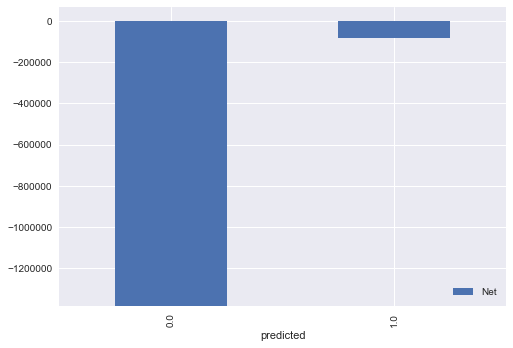

In [29]:
#produce example of how much would be lost or won to betting
#positive line is underdog, negative is favorite. negative diff is a loss by that amount and vice versa
#=IF(E2>0,E2/100*F2,ABS(F2/E2*100))  E2 is odds, F2 is amount (can set amount to 100)

predictions = pd.DataFrame({'diff':y_test,'predicted':nn_pred,'line':Line,'opp.line':OppLine})
predictions['Success'] = predictions['diff']*predictions['predicted']>0
predictions['outcomeline1'] = [i/100*1000 if i > 0 else abs(1000/i*100) for i in predictions['line']]
predictions['outcomeline2'] = [i/100*1000 if i > 0 else abs(1000/i*100) for i in predictions['opp.line']]
predictions['predicted'] = predictions['predicted'].apply(lambda number : round(number * 2) / 2)
Net=[]
for index,row in predictions.iterrows():
    if (row['diff']<0) & (row['predicted']<0) & (row['opp.line']<0):
        Net.append(row['outcomeline2'])
    elif (row['diff']<0) & (row['predicted']<0) & (row['line']<0):
            Net.append(row['outcomeline1'])
    elif (row['diff']>0) & (row['predicted']>0) & (row['line']<0):
        Net.append(row['outcomeline1'])
    elif (row['diff']>0) & (row['predicted']>0) & (row['opp.line']<0):
        Net.append(row['outcomeline2'])
    else:
        Net.append(-1000)
predictions['Net'] = Net
#is this possible without previous point spread? we can check win vs lost.
# - 1000 for each row of False, OutcomeWin for each true row... also could slice and dice by win margins, may find betting strat

#ALL PREDICTIONS
#never predicts underdog -- #$168,000 in losses

### Predicting on Live Data

In [57]:
def predLive():
    test = pd.read_csv("final_testset.csv")
    
    for index, row in test.iterrows():
        
        #exclude data if game already predicted
        if pd.Series(row['PredDiff']).isnull().all():
            
            #predict with train columns from model training
            row_train = row[colsToTrain]
            live = pd.Series(model.predict(row_train))
            
            #convert predicted result to nearest half integer 
            live = live.apply(lambda number : round(number * 2) / 2)
            
            #write prediction to row
            test.at[index,'PredDiff'] = live
        else:
            print("No rows to predict")
    
    #overwrite testset w/ predicted differential
    test.to_csv("final_testset.csv",index=False)
        
    #optional: use a webscraping library to extract training features automatically.
        #pull in all team data for traditional/advanced, store in frames, with headers
        #then just mapping exercise

In [58]:
predLive()

No rows to predict


### Classification Model

In [20]:
from sklearn.neural_network import MLPClassifier

In [21]:
%%time

#NN model
model_NN = MLPClassifier(hidden_layer_sizes=(10,10,10,10,10,10),random_state=42)

#split data
X_train,X_test,y_train,y_test = train_test_split(train,target_classifier,test_size=0.33,random_state=42)
Line = X_test['Line']
OppLine = X_test['Opp.Line']

#normalization
norm = Normalizer()
X_train = pd.DataFrame(norm.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(norm.fit_transform(X_test),columns=X_test.columns)


#predict and store predictions
model_NN.fit(X_train, y_train)
nn_pred = model_NN.predict(X_test)
nn_proba = model_NN.predict_proba(X_test)

Wall time: 719 ms


In [48]:
print(model_NN.n_layers_,model_NN.n_iter_)

8 19


In [22]:
#accuracy score
model_NN.score(X_test,y_test)

0.678546224417784

In [30]:
predictions['PredProba'] = nn_proba[:,1]
predictions['PredProba.opp'] = nn_proba[:,0]

In [38]:
predictions['EV_1'] = predictions['PredProba']*predictions['outcomeline1']
predictions['EV_2'] = predictions['PredProba.opp']*predictions['outcomeline2']
predictions['BestEV'] = predictions[['EV_1','EV_2']].max(axis=1)
predictions['makeBet'] = predictions['BestEV'] >1000

In [42]:
sum(predictions['makeBet'])/len(predictions)

0.16866619618913198

In [45]:
predictions.to_csv('bets.csv')

### Scraping NBA.com for Input Data

In [7]:
from selenium import webdriver

In [10]:
trad_url = "https://stats.nba.com/teams/traditional/?sort=W_PCT&dir=-1&Season=2018-19&SeasonType=Regular%20Season&LastNGames=10"
adv_url = "https://stats.nba.com/teams/advanced/?sort=W&dir=-1&Season=2018-19&SeasonType=Regular%20Season&LastNGames=10"

In [126]:
def getData(url):
    
    #get data w/ selenium webdriver, update path as necessary
    browser = webdriver.Chrome(executable_path='C:/Users/me1035/chromedriver.exe')
    browser.get(url)
    table = browser.find_element_by_class_name('nba-stat-table__overflow').text.split('\n')
    stats = []
    teams = []
    
    #advanced stats has astRatio with a newline character, which causes column issues -- correction for that
    if url == "https://stats.nba.com/teams/advanced/?sort=W&dir=-1&Season=2018-19&SeasonType=Regular%20Season&LastNGames=10":
        table[0] = table[0] + table[1]
        table.pop(1)
        table.pop(1)
    
    #iterate through lines and create lists to create dataframe
    for line_id, lines in enumerate(table):
        if line_id == 0:
            column_names = lines.split(' ')[1:]
        else:
            if line_id % 3 == 2:
                teams.append(lines)
            if line_id % 3 == 0:
                stats.append([i for i in lines.split(' ')])
            
    return pd.DataFrame(stats,columns=column_names,index=[teams])

In [128]:
#next step is to chain out to http://www.espn.com/nba/lines/_/date to get today's games + betting lines

In [ ]:
#map team to team